# Introduction

The main point of this project is representing a cell tower network as a graph and applying concepts of Graph Signal Processing. In the Graph domain, we can then apply concepts of virtual signal processing such as defining the Laplacian, eigencomposition and signal filtering.


## Defining a graph

A weighted, undirected graph is defined as a set of vertices $V$ and edges $E$. For our problem, the vertices are defined as being the cell towers in the network and the edges $E$ are the spatial relations between them. Each vertex takes a value $x$ which can depend on the application and is independent of the modelling of the edges. In our case, it can be taken to be the devices that are connected at time point $t$ on a particular vertex (cell tower), the average signal strength of the connected devices etc.

Modelling the edges is a non-trivial task as it highly depends on both the problem we want to solve. We can assume that we want to measure the devices connected to each tower and hence model traffic in a given region. In this case, it would make sense for the edges to encode spatial information (towers that are close-by can be considered "connected" and part of a local network). Reality is of course much more complex as there are parameters such as signal attenuation, properties of the networking protocol and individual tower parameters. Moreover, there are multiple external attenuation factors such as local buildings as well as network traffic that have an impact on the tower that the user eventually connects to.

As a first approach to the problem, we will consider the problem of an unweighted graph: given the rated radius of the cell tower, two vertices will be considered connected if they have overlapping regions and unconnected otherwise. We will later build on top of this with a weighted version taking some of the aforementioned parameters into account that gives a more accurate version of the cell network.

## Getting the data

Actual cell tower data is gathered from [OpenCellid](https://www.opencellid.org) project by Unwired Labs which offers an open API for educational and recreational purposes under CC BY-SA 4.0. Data can also be collected and contributed using one of the recommended [open applications](https://wiki.opencellid.org/wiki/Data_sources). 

We will start by downloading the CSV containing all the cell towers of Greenland for a grant total of 223 (registered) cell towers. For now we will only focus on the latitude, longitude and range values. We will also not care about different technologies


In [1]:
import numpy as np
import pandas as pd

# This is my actual API capped at 5000 requests/day. You can sign up and generate your own, but if you want just 
# to make a few calls and demo it out feel free to use this one responsibly :) 
API = "pk.b6a83dab0c578fe75e02f531a6836b27" 

df = pd.read_csv("data/greenland_cells.csv", delimiter=",", header=0, 
                          names=["Radio Type","MCC","MNC","LAC","CID","P1","Longitude","Latitude","Radius","Measurements","P2","Created","Updated","P3"])
display(df)

Radio Type  MCC  MNC   LAC       CID   P1  Longitude   Latitude  Radius  \
0         UMTS  290    1   101     68577    0 -45.242111  60.142593    1000   
1         UMTS  290    1  1001     66588    0 -51.710646  64.181741    1000   
2         UMTS  290    1  1001     66590    0 -51.704483  64.189682    1000   
3         UMTS  290    1   101     68576    0 -45.249252  60.142593    1000   
4         UMTS  290    1  1001     66587    0 -51.700974  64.189682    1000   
..         ...  ...  ...   ...       ...  ...        ...        ...     ...   
217        LTE  290    1  4400    957707   -1 -46.043347  60.720779    1000   
218        LTE  290    1  4400   1144647   -1 -46.040403  60.718768    1000   
219        LTE  290    1  4400   1147209   -1 -46.036513  60.718716    1000   
220        LTE  290    1  4400   1144648   -1 -46.037908  60.718270    1000   
221       UMTS  290    1  4400  65639069  321 -46.036194  60.718868    1000   

     Measurements  P2     Created     Updated  P3  
0              15   1  1363713503  1384882155   0  
1              23   1  1364570950  1396340419   0  
2               9   1  1365678440  1426242186   0  
3               1   1  1365797838  1365797838   0  
4               5   1  1365869610  1365869610   0  
..            ...  ..         ...         ...  ..  
217             7   1  1688737295  1688737329   0  
218            10   1  1688737335  1688737935   0  
219            12   1  1688737435  1688737831   0  
220             4   1  1688737475  1688737905   0  
221             1   1  1688738005  1688738005   0  

[222 rows x 14 columns]

We can parse and visualize the data just to get a general idea about the general form of the graph (e.g. number of clusters).

<ipython-input-2-f194e0d29df2>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


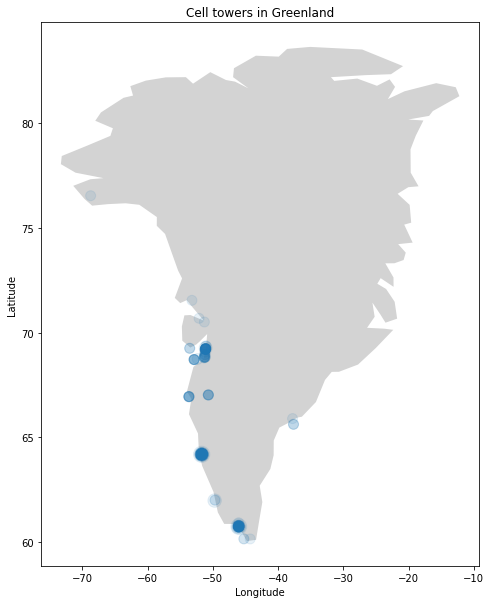

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))

countries[countries["name"] == "Greenland"].plot(color="lightgrey", ax=ax)
df.plot(x="Longitude", y="Latitude", kind="scatter", s=df["Radius"]/10, alpha= 0.1, ax=ax, title="Cell towers in Greenland")
plt.show()

In [3]:
cell_points_coords = list(zip(df["Longitude"], df["Latitude"]))
cell_points_coords


[(-45.242111, 60.142593),
 (-51.710646, 64.181741),
 (-51.704483, 64.189682),
 (-45.249252319336, 60.142593383789),
 (-51.700973510742, 64.189682006836),
 (-51.714706420898, 64.178695678711),
 (-52.117080688477, 70.67985534668),
 (-46.034129, 60.721678),
 (-51.709999, 64.190663),
 (-50.692063, 67.019577),
 (-50.687484741211, 67.021408081055),
 (-51.735306, 64.172745),
 (-51.733017, 64.17366),
 (-51.718139, 64.180069),
 (-51.719055, 64.178925),
 (-53.68537902832, 66.932144165039),
 (-53.68537902832, 66.932144165039),
 (-50.693665, 67.019348),
 (-53.670272827148, 66.937637329102),
 (-53.670272827148, 66.937637329102),
 (-52.339233, 68.736649),
 (-46.046927, 60.916131),
 (-46.041641, 60.720406),
 (-46.03811, 60.718002),
 (-52.871017456055, 68.709182739258),
 (-52.871017456055, 68.709182739258),
 (-46.056751, 60.711961),
 (-51.735305786133, 64.17594909668),
 (-51.71367, 64.182227),
 (-51.719544, 64.185002),
 (-51.732043, 64.177751),
 (-51.728799, 64.181427),
 (-51.725007, 64.182816),
 (-51

In [4]:
cell_points_radius = list(df["Radius"])
cell_points_radius

[1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1634,
 1003,
 1000,
 1000,
 1000,
 1000,
 1000,
 1061,
 1000,
 1000,
 1000,
 1000,
 1000,
 1173,
 1000,
 1000,
 1000,
 1000,
 1000,
 1892,
 1000,
 2679,
 1736,
 1685,
 1273,
 1035,
 1378,
 1000,
 1970,
 1000,
 1478,
 1000,
 1790,
 1000,
 1000,
 1000,
 1000,
 1569,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1808,
 1000,
 1000,
 1000,
 1000,
 1000,
 1562,
 500,
 1000,
 1000,
 1000,
 1000,
 1062,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1692,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1815,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,


## Basic assumptions

As discussed before, for the first version of the problem we only consider undirected and unweighted graphs with the neighborhood of each vertex given by the towers within its given radius. We are also called to make a choice regarding the projection of the points. We are given the geographic coordinates of the towers (in degrees) when we want to calculate neighborhoods of radius R calculated in meters. We have multiple options we can consider:

* Taking an azimuthian projection with the center point being the geographical barycenter of all the given points. Distances are preserved for another point and we can then assume that distortion is minimal for the area we are observing (TODO: Would be nice to estimate how much). This is limited according to the area we are observing since distortions become significant as we move away from the central point.
* For each vertex, taking an azimuthian projection with the center point being the vertex itself and calculating the neighborhood according to the projection. This could be accurate and easy to calculate for the 223 Greenlandish station but easily explodes when considering larger, urban areas
* A hybrid method that according to the accepted distortion error, partitions the given points into separate region where the distortion is considered "acceptable" and applies the first method by taking the mapping with the centerpoint being the barycenter
* Translating the points into a 3D reference frame and taking the three-dimensional balls B(x;r) with the Euclidean metric

For now, we are following the last option which is considered to be accurate enough. To prove the assertion, we consider a radius of 1000 m which is within the order of magnitude obf our data. Assuming Earth is a sphere of radius 6378137 m, we can calculate the rate of change of the angle $\theta$ when moving to one direction (since it's a sphere, we don't have to worry about principle directions and our position in the surface, we can essentially treat the problem as we would a sphere) as $2\pi\cdot7.8e^{-8}\ \text{rad}/\text{m}$ which brings us to an angle of $0.00049\ \text{rad}$ for a distance of 1000 meters.

(if we are still not convinved, we can consider take the Earth ellipsoid and calculate the principal curvatures at the extrema)

(also note that we want to search for a solution that uses the Euclidean metric since this allows us to use efficient data structures for distance calculations between points)

## Calculating adjacency matrix

For the calculation of the adjacancy matrix, we first take the spherical coordinates of the stations (all calculated in meters). 


In [5]:
def geo_to_spherical(u):
    lat, lon = u
    # Convert to rad
    lat *= np.pi / 180
    lon *= np.pi / 180
    r = 6378137
    return (r * np.sin(lat) * np.cos(lon), r * np.sin(lat) * np.sin(lon), r * np.cos(lat))

cell_points_spherical = list(map(geo_to_spherical, cell_points_coords))
cell_points_spherical


[(-2254752.245100444, -3927888.4310234813, 4490926.004446678),
 (-2180266.4825298754, -4506432.2997834105, 3952105.4620789923),
 (-2179456.7841819897, -4506351.709627631, 3952643.923475555),
 (-2255030.8674536035, -3928373.8657028805, 4490361.4719600305),
 (-2179351.3674126486, -4506133.746118219, 3952950.5271657794),
 (-2180627.9866640135, -4506568.5119607635, 3951750.678060346),
 (-1665497.7163032086, -4750559.849723083, 3916494.614059465),
 (-2245086.3846822027, -4004246.046131161, 4427892.536876495),
 (-2179545.291928051, -4506731.5756812515, 3952161.992626422),
 (-1926744.577800561, -4543441.373850717, 4040473.6609791974),
 (-1926473.3304161273, -4543205.694288765, 4040867.9905864946),
 (-2181714.855128237, -4507620.574618936, 3949950.460063244),
 (-2181574.1214693007, -4507513.370647176, 3950150.523301787),
 (-2180623.078784906, -4506833.883374168, 3951450.7369711893),
 (-2180740.5797112333, -4506847.207790925, 3951370.693872805),
 (-2013708.1827560926, -4728421.77600377, 3777252

In [6]:
import scipy 
from scipy import spatial

cell_kdtree = spatial.KDTree(cell_points_spherical)
points_n = len(cell_points_spherical)
cell_adjacency = scipy.sparse.dok_matrix((points_n, points_n), dtype=bool)

for i, x in enumerate(zip(cell_points_spherical, cell_points_radius)):
    cell, r = x
    neigh = cell_kdtree.query_ball_point(cell, r)
    cell_adjacency[neigh, i] = True
    cell_adjacency[i, neigh] = True
 
# Set diagonal back to zero
cell_adjacency -= scipy.sparse.identity(points_n)

In [7]:
cell_adjacency.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

For the adjacency matrix (which in our unweighted case coincides with the weight matrix) can be used to easily calculate the degree of each node

In [8]:
cell_degree = sum(cell_adjacency).toarray()[0]
cell_degree

array([ 1., 24., 17.,  1.,  8., 20.,  0., 18., 18.,  5.,  5., 38., 39.,
       19., 19.,  1.,  1.,  5.,  3.,  3.,  0.,  0., 17., 17.,  6.,  6.,
        5., 41., 56., 38., 56., 42., 20., 33.,  0., 24.,  3.,  6.,  3.,
       22., 17.,  1.,  1.,  7., 32., 20., 30., 40., 39., 41., 43., 21.,
        0.,  0., 36.,  6.,  4., 34., 10., 14., 17.,  6.,  6., 17.,  1.,
        1.,  5.,  6.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,
        0.,  0.,  0.,  1.,  0.,  6.,  1.,  1.,  6.,  0.,  6., 36., 33.,
       42., 32.,  4.,  1., 41., 41., 41.,  0.,  2.,  2.,  1., 41.,  0.,
        4.,  0.,  5., 40.,  2., 42.,  3., 14.,  3.,  6.,  6.,  6.,  6.,
        2.,  2.,  6.,  2., 33., 36., 26., 26.,  0.,  0.,  1.,  1.,  0.,
        3., 42., 37.,  4., 40., 42.,  0., 16.,  3., 32., 41., 16., 41.,
       17., 16.,  5., 40., 16.,  5.,  3., 11.,  3., 18., 16., 32., 37.,
       36.,  1.,  5.,  7., 41.,  6.,  7.,  3.,  4., 19.,  4.,  4.,  3.,
       19., 19., 19., 30., 38., 21., 32., 12.,  2., 30., 18., 30

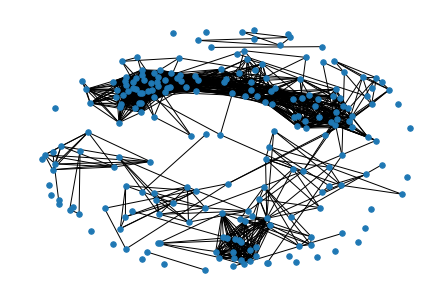

In [9]:
import networkx as nx
G = nx.from_numpy_array(cell_adjacency.toarray())
#TODO: More efficient command but doesn't work currently because of incompatible versions
# nx.from_scipy_sparse_matrix(cell_adjacency)

nx.draw(G, node_size = 30, pos=nx.spring_layout(G, k=1, iterations=120), alpha = 1)

# Here I understood I didn't make the best choise for a graph. None of the layouts I tried
# worked well with graphs that had both maby unconnected components but also strongly connected
# neighborhoods

# Graph Signal Processing


## Laplacian

The Laplacian for a graph signal is given by the matrix $L = D - A$ where $D$ is the diagonal degree matrix and $A$ is the adjacency matrix. We also define $N(i)$ as the neighborhoods of $i$, $N(i) = \{j | A_{ij} \neq 0\}$ 

Since $D$ is diagonal and $A$ has it's diagonal set to zero, we can see that the diagonal of $L$ is defined as $L_{ii} = D_i = \sum_{j} w_{ij} = \sum_{j \in N(i)} w_{ij}$. For $i\neq j$ $L_{ij} = -A_{ij} = - w_{ij}$. Note that the definition is given for the general weighted and undirected graphs.

If we consider applying the graph operator to a signal $x$ we have, $y = Lx$

$$y_i = \sum_{j} L_{ij}x_j = L_{ii}x_{i} + \sum_{j\in N(i)} (-w_{ij})x_j = \sum_{j\in N(i)} w_{ij}(x_i - x_j)$$

This means that $L$ is intuitively the weighted average of the neighbours of $i$

### Eigenvectors and eigenvalues

We will now try to give an intuitive explanation of the eigenvectors and eigenvalues of the graph Laplacian, starting with the kernel.

For $Lx = 0$ by going back to the closed formula mentioned above and a few algebraic manipulation we can prove that we want each neighborhood to have constant values. If we have a connected graph, then we can prove that all the nodes will have a constant value to each other and as such, there is only one eigenvector $\{1,\ 1,\ \dots,\ 1\}$. If the graph is not connected, then we can have $n$ different eigenvectors. From this it follows that the multiplicity of the eigenvalues shows the number of connected of components in the graph.

For a rigorous and in-depth treatment you can refer to [1].

[1]: http://blog.shriphani.com/docs/Luxburg07_tutorial.pdf


In [10]:
cell_laplacian = cell_adjacency - scipy.sparse.diags(cell_degree)

cell_laplacian_eigenvalues, cell_laplacian_eigenvectors = scipy.sparse.linalg.eigs(cell_laplacian, k = (points_n - 2))

We can see that there are various values approximating zero. Some complex eigenvalues also appear, with the complex part however being negligible. This is possibly due to arithmetic erros - sparse matrices aren't usually computed analytically but approximated iteratively since those methods can usually gurantee relatively fast convergence. Scipy uses ARPACK for calculating the eignevalues which is not suitable to small eigenvalues. 

To avoid precision headaches (for now) we will take the performance hit and compute the eigenvalue with a direct method by first converting to a regular array

In [11]:
from numpy import linalg

cell_laplacian_eigenvalues, cell_laplacian_eigenvectors =  linalg.eig(cell_laplacian.toarray())

In [12]:
# Filter sufficiently small values as they are most likely due to float-point arithmetic errors
cell_laplacian_l0_mult = len(list(filter(lambda x: x**2 < 10**-15, cell_laplacian_eigenvalues)))
cell_laplacian_l0_mult

48

We can now cross-check by directly calculating the number of connected components from the adjacency matrix 

In [13]:
 scipy.sparse.csgraph.connected_components(cell_adjacency)

(48,
 array([ 0,  1,  1,  0,  1,  1,  2,  3,  1,  4,  4,  1,  1,  1,  1,  5,  5,
         4,  6,  6,  7,  8,  3,  3,  9,  9,  3,  1,  1,  1,  1,  1,  1,  1,
        10,  1,  1,  1,  1,  1,  1, 11, 11,  1,  1,  1,  1,  1,  1,  1,  1,
         1, 12, 13,  1,  1,  1,  1,  1,  1,  3, 14,  1,  1, 15, 16,  4, 14,
        17, 18, 19, 20, 21, 22, 23, 24,  1, 25, 26, 27, 28, 16, 29, 14, 30,
        30, 14, 31, 14,  1,  1,  1,  1, 14, 17,  1,  1,  1, 32, 14, 14, 15,
         1, 33, 14, 34,  4,  1, 17,  1, 17,  1,  1,  9,  9,  9,  9, 35, 35,
         9, 35,  1,  1,  1,  1, 36, 37, 38, 38, 39,  6,  1,  1,  1,  1,  1,
        40,  1,  6,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1, 41,  1,  1,  1,  1,  1, 42, 42,  1, 42, 42, 42,  1,
         1,  1,  1,  1,  1,  1,  1, 42,  1,  1,  1,  1, 43, 41, 44,  1, 42,
        14, 45, 45, 45, 45, 46,  1,  1,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3, 47, 47, 47, 47, 47,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
       

### Fourier decomposition

Before defining the Fourier transformation on graphs, we first consider the Laplacian on $R^n$:

$$f \rightarrow \Delta f = \sum_{j=1}^n \frac{\partial^2 f}{\partial x_j^2}$$

We can verify that $e^{2 \pi i \xi t}$ are eigenfunctions of $\Delta$ with eigenvalues $-4\pi^2\left|\xi\right|^2$:

$$\Delta e^{2 \pi \xi t} = -4\pi^2\left|\xi\right|^2 e^{2 \pi i \xi t}$$

Similarly, in the graph domain we can expand the function in terms of eigenvectors of the Laplacian:

$$\sum_{i=1}^N f(i) u_l^*(i)$$

Analogously to the $R^n$ case, lower eigenvalues carry low-frequency information, whereas higher level components carry the high-frequency information. This can also be expanded to introduce the concept of filtering in the graph domain

In [14]:
"""TODO
# We consider that the imaginary part is negligible 
node_color = list(map(lambda x: round(np.real(x), 3), cell_laplacian_eigenvectors[0]))
node_color = node_color/np.max(node_color)

nx.draw(G, node_size = 30, pos=nx.spring_layout(G, k=1, iterations=120),
        node_color = node_color,  cmap=plt.cm.seismic)
"""

'TODO\n# We consider that the imaginary part is negligible \nnode_color = list(map(lambda x: round(np.real(x), 3), cell_laplacian_eigenvectors[0]))\nnode_color = node_color/np.max(node_color)\n\nnx.draw(G, node_size = 30, pos=nx.spring_layout(G, k=1, iterations=120),\n        node_color = node_color,  cmap=plt.cm.seismic)\n'

# TODO:

- Modelling with more complicated assumptions (and preferably a connected network since we've taken a glance in the unconnected case). Would be interesting to see how restrictions of both the physical layer but also the protocol could be encoded in the adjacency matrix
- Less handwavy explanations 
- Dig a bit more into Fourier since it really lies in the heart of all of this. Draw parallels between the classical SP and GSP. Showcase filtering.

GSP shines where you don't have strictly spatial relation between objects. Similar approaches can be used to define etc relations between users in a platform, patients, actors in a process etc
communication, antenna arrays for signal strenght??